In [10]:
import numpy as np 
from sklearn.datasets import load_iris
data = load_iris()
print(data.keys())
list(data.target_names)

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


['setosa', 'versicolor', 'virginica']

In [18]:
import torch 
import torch.nn as nn 

DEVICE = "cuda:0"

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4,32),
            nn.ReLU(),
            nn.Linear(32,32),
            nn.ReLU(),
            nn.Linear(32, 3),
        )
    def forward(self, x ):
        return self.net(x)

In [21]:
from torch.utils.data import DataLoader, Dataset 

class ToyDataset(Dataset):
    def __init__(self, data, target):
        self.X = data 
        self.Y = target 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx]).to(DEVICE).float()
        y = torch.tensor(self.Y[idx]).to(DEVICE)
        return (x,y) 
    
dataset = ToyDataset(data.data, data.target) 
loader = DataLoader(dataset, batch_size=4)

In [24]:
model = Model().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 100
for epoch in range(epochs):
    running_loss = 0    
    for i, (x,y) in enumerate(loader):
        y_hat = model(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch%10 ==0:
        print("Loss : ", running_loss/(i+1))


Loss :  1.3089569109050851
Loss :  0.516803697928002
Loss :  0.4067584616867335
Loss :  0.29593314905650914
Loss :  0.24960938366252536
Loss :  0.17469863805576766
Loss :  0.15244660340555893
Loss :  0.14256701399082025
Loss :  0.13237690069639174
Loss :  0.12322279147644478


In [109]:
MEAN = data.data.mean(axis=0)
STD = data.data.std(axis=0)

model.eval()
target_x = 0
x_bins = 30
sampling_num = 10
predictions = np.zeros(shape=(3, x_bins, sampling_num))
for i, x in enumerate(np.linspace(-data.data[target_x,:].min(),data.data[target_x,:].max(), x_bins)):
    X = np.random.multivariate_normal(MEAN, np.diag(STD)**2, sampling_num)
    X = torch.tensor(X, device=DEVICE).float()
    with torch.no_grad():
        Y = model.forward(X)
    classes = torch.softmax(Y[:,].cpu().detach(), -1).numpy()
    for c in range(3):
        predictions[c,i,:] = classes[:,c] 

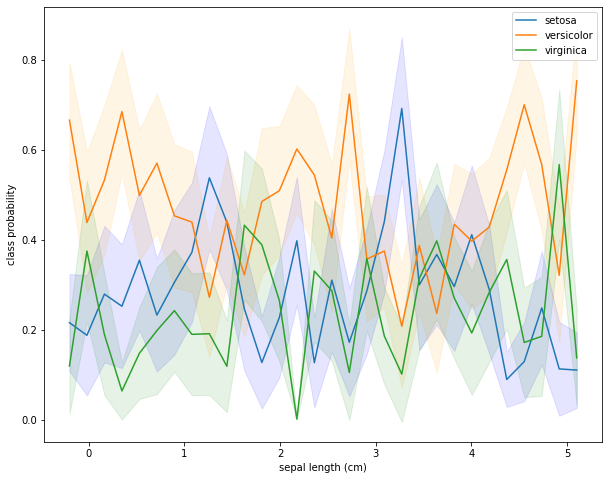

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns  
import pandas as pd 

X_interval = np.linspace(-data.data[target_x,:].min(),data.data[target_x,:].max(), x_bins)
fig, ax = plt.subplots( facecolor="white", figsize=(10,8))

for c in range(3):
    ci = 1.96 * np.std(predictions[c], axis=-1)/np.sqrt(len(predictions[c]))
    PDP = predictions[c,:,:].mean(axis=-1)
    ax.plot(X_interval, PDP)

plt.legend(data.target_names)
plt.xlabel(data.feature_names[target_x])
plt.ylabel("class probability")
for c in range(3):
    ci = 1.96 * np.std(predictions[c], axis=-1)/np.sqrt(len(predictions[c]))
    PDP = predictions[c,:,:].mean(axis=-1)
    ax.fill_between(X_interval, (PDP-ci), (PDP+ci), color=['b', 'orange', 'g'][c], alpha=.1)



## For all X features 

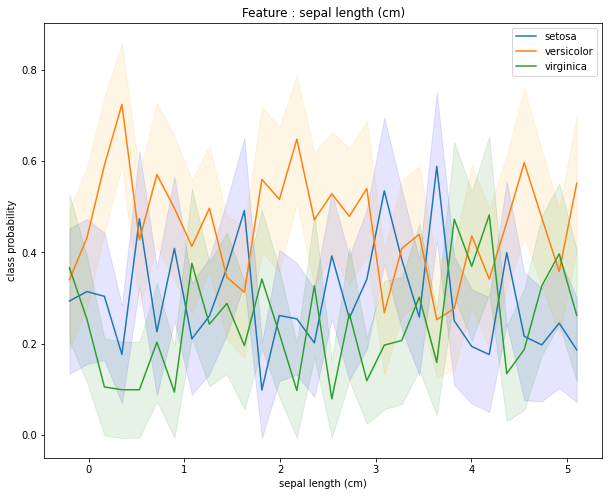

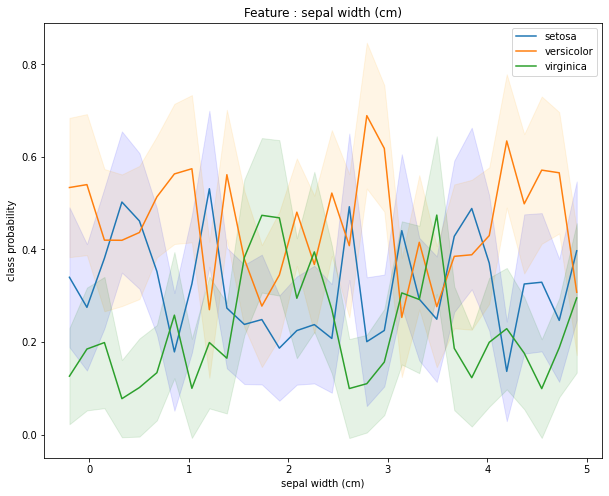

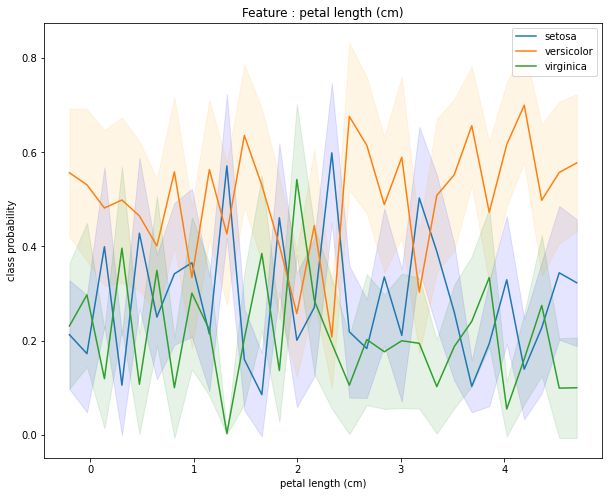

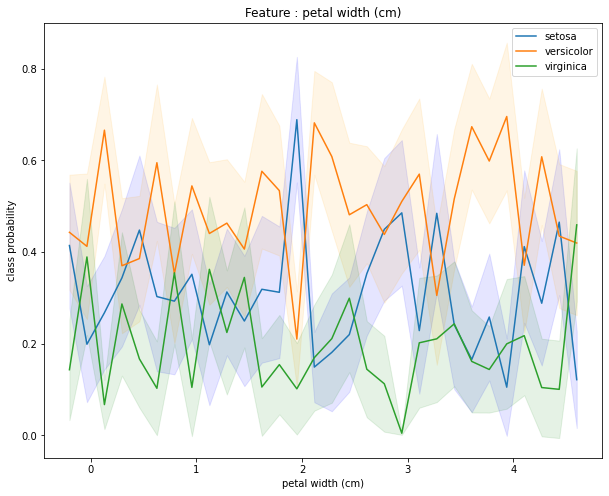

In [110]:

model.eval()

for target_x in range(4):
    x_bins = 30
    sampling_num = 10
    predictions = np.zeros(shape=(3, x_bins, sampling_num))
    for i, x in enumerate(np.linspace(-data.data[target_x,:].min(),data.data[target_x,:].max(), x_bins)):
        X = np.random.multivariate_normal(MEAN, np.diag(STD)**2, sampling_num)
        X = torch.tensor(X, device=DEVICE).float()
        with torch.no_grad():
            Y = model.forward(X)
        classes = torch.softmax(Y[:,].cpu().detach(), -1).numpy()
        for c in range(3):
            predictions[c,i,:] = classes[:,c] 


    X_interval = np.linspace(-data.data[target_x,:].min(),data.data[target_x,:].max(), x_bins)
    fig, ax = plt.subplots( facecolor="white", figsize=(10,8))

    for c in range(3):
        ci = 1.96 * np.std(predictions[c], axis=-1)/np.sqrt(len(predictions[c]))
        PDP = predictions[c,:,:].mean(axis=-1)
        ax.plot(X_interval, PDP)

    plt.title("Feature : {0}".format(data.feature_names[target_x]))
    plt.legend(data.target_names)
    plt.xlabel(data.feature_names[target_x])
    plt.ylabel("class probability")
    for c in range(3):
        ci = 1.96 * np.std(predictions[c], axis=-1)/np.sqrt(len(predictions[c]))
        PDP = predictions[c,:,:].mean(axis=-1)
        ax.fill_between(X_interval, (PDP-ci), (PDP+ci), color=['b', 'orange', 'g'][c], alpha=.1)
